## IMPORT

In [2]:
# import 

# libraries

from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight');
plt.rcParams['font.size'] = 14;
plt.figure(figsize=(12,5));
palette = sns.color_palette('Paired', 10);

# map

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

# sci-kit learn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config; set_config(display='diagram')

<Figure size 864x360 with 0 Axes>

In [3]:
data = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows=1000000)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# DATA ANALYSIS

In [4]:
data = data.drop(["key"],axis=1)

In [5]:
size_before = len(data)
data = data.drop_duplicates()
size_after = len(data)
print(str(size_before - size_after) + " duplicates were removed.")

0 duplicates were removed.


In [6]:
100 * data.isnull().sum().sort_values(ascending=False)/len(data)

dropoff_longitude    0.001
dropoff_latitude     0.001
fare_amount          0.000
pickup_datetime      0.000
pickup_longitude     0.000
pickup_latitude      0.000
passenger_count      0.000
dtype: float64

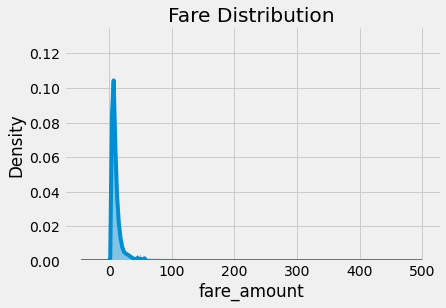

In [8]:
#exploring data

def plot_dist(series=data["fare_amount"], title = "Fare Distribution"):
    sns.histplot(series, kde=True, stat='density',discrete=True)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

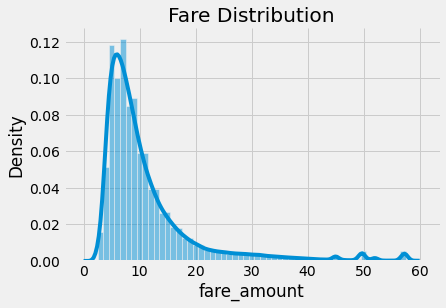

In [10]:
#dropping absurd values

data = data[data.fare_amount.between(0,60)]
plot_dist(data.fare_amount)

In [16]:
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5)), include_lowest=True).astype('str')

# Uppermost bin
data['fare-bin'] = data['fare-bin'].replace(np.nan, '[45+]')

# apply this to clean up the first bin's label
data['fare-bin'] = data['fare-bin'].apply(lambda x: x.replace('-0.001', '0'))

# sort by fare the correct look in the chart
data = data.sort_values(by='fare_amount')

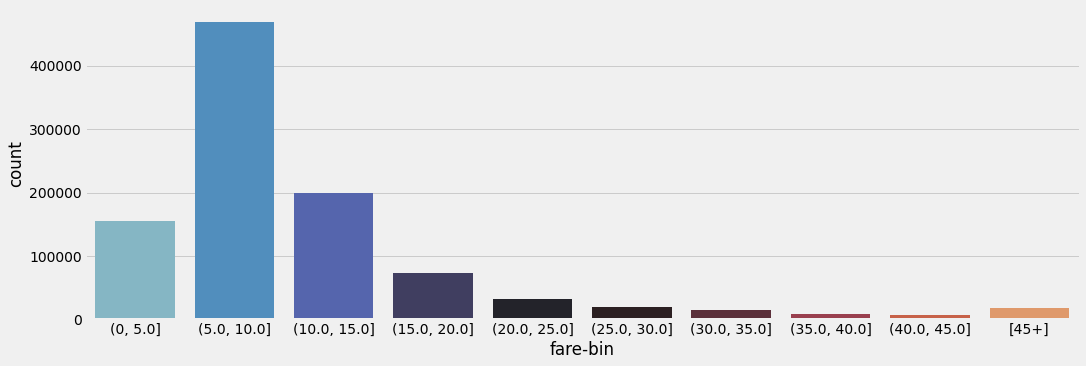

In [22]:
sns.catplot(x="fare-bin", kind="count", palette= "icefire", data=data, height=5, aspect=3);
sns.despine()
plt.show()

**ANALYSING FEATURES**

In [23]:
# passanger_count feature

data.passenger_count.describe()

count    997297.000000
mean          1.685096
std           1.324201
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

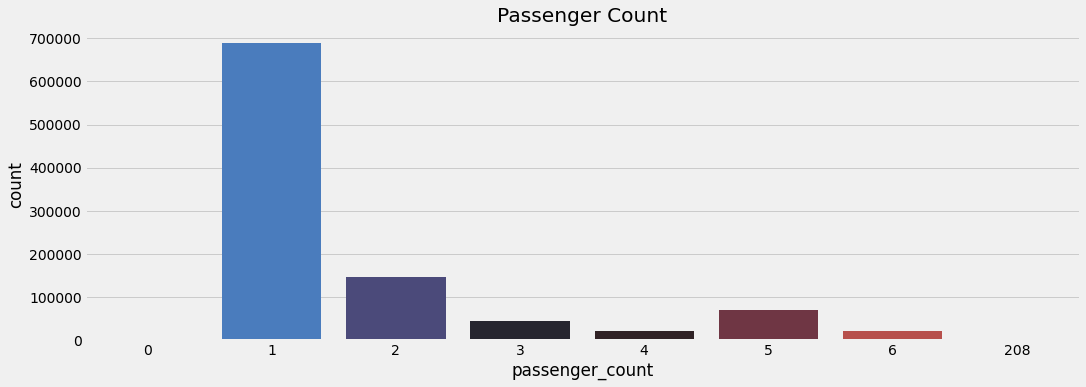

In [25]:
sns.catplot(x="passenger_count", kind="count", palette="icefire", data=data, height=5, aspect=3);
sns.despine()
plt.title('Passenger Count');
plt.show()

In [26]:
# pickup_datetime feature

def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [28]:
data = extract_time_features(data.drop(["fare-bin"], axis=1))
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_bin,dow,hour,month,year
0,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,"(0, 5.0]",2,10,4,2015
1,0.0,2015-03-28 18:14:09 UTC,-73.987694,40.764881,-73.990150,40.761581,4,"(0, 5.0]",5,14,3,2015
2,0.0,2015-03-21 21:27:02 UTC,-73.982101,40.770557,0.000000,0.000000,2,"(0, 5.0]",5,17,3,2015
3,0.0,2010-02-26 22:10:53 UTC,-73.812794,40.695922,-73.993577,40.749743,1,"(0, 5.0]",4,17,2,2010
4,0.0,2015-02-22 19:26:37 UTC,-73.994370,40.750725,-73.994370,40.750721,1,"(0, 5.0]",6,14,2,2015


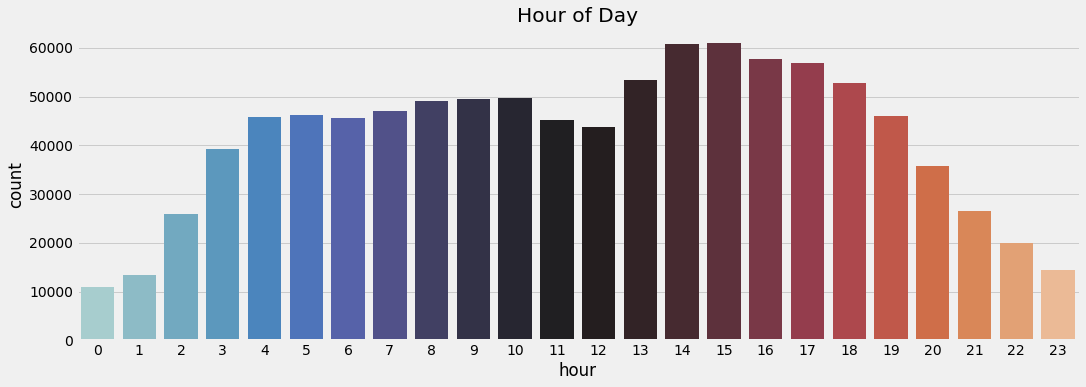

In [34]:
# taxi trip repartition by hour of the day

sns.catplot(x="hour", kind="count", palette="icefire", data=data, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

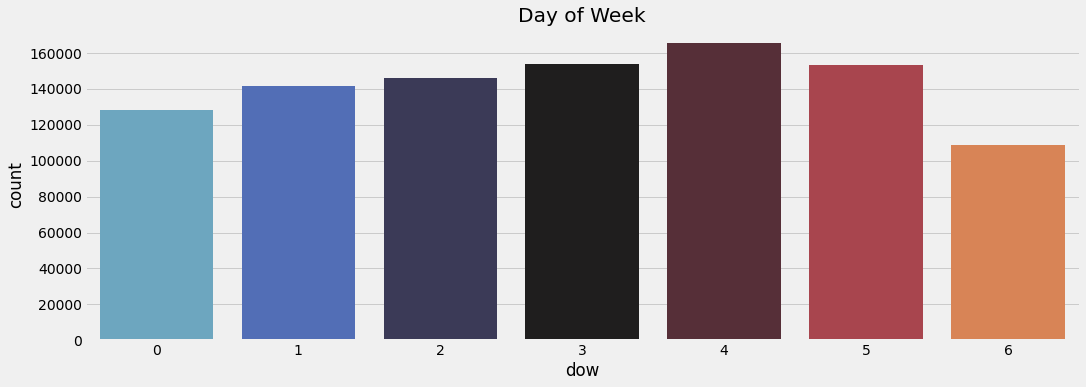

In [35]:
# taxi trip repartition by day of the week

sns.catplot(x="dow", kind="count", palette="icefire", data=data, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

### Finding boundaries from test set and removing outliers from training set

In [36]:
data_test = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/test.csv")

In [37]:
for col in ["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"]:
    MIN = data_test[col].min()
    MAX = data_test[col].max()
    
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [38]:
data = data[data["pickup_latitude"].between(left = 40, right = 42 )]
data = data[data["pickup_longitude"].between(left = -74.3, right = -72.9 )]
data = data[data["dropoff_latitude"].between(left = 40, right = 42 )]
data = data[data["dropoff_longitude"].between(left = -74, right = -72.9 )]

In [39]:
center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)

In [40]:
data["count"] =1
heatmap_data = data.head(10000)[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

In [41]:
heatmap_data_by_hour = []
__data__ = data.head(10000)
for hour in data.hour.sort_values().unique():
    _data = __data__[__data__.hour == hour][['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_data)

In [42]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5, 
                gradient=gradient, 
                min_opacity=0.5, max_opacity=0.8, 
                use_local_extrema=False).add_to(m2)
m2

In [47]:
#Distance feature

def haversine_distance(df,
                       start_lat="start_lat",
                       start_lon="start_lon",
                       end_lat="end_lat",
                       end_lon="end_lon"):
    
    # Calculate the great circle distance between two points 
    #on the earth (specified in decimal degrees).
       
    #Vectorized version of the haversine distance for pandas df
    #Computes distance in kms
    
    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6371 * c
    return haversine_distance

data["distance"] = haversine_distance(data, 
                                      start_lat="pickup_latitude", start_lon="pickup_longitude",
                                      end_lat="dropoff_latitude", end_lon="dropoff_longitude"
                                     )

In [49]:
data.distance.describe()

count    847916.000000
mean          3.288393
std           3.717411
min           0.000000
25%           1.236222
50%           2.112549
75%           3.837169
max         104.254968
Name: distance, dtype: float64

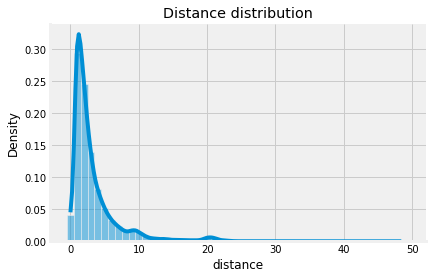

In [50]:
%matplotlib inline
plot_dist(series=data[data.distance<50].distance, title = "Distance distribution")

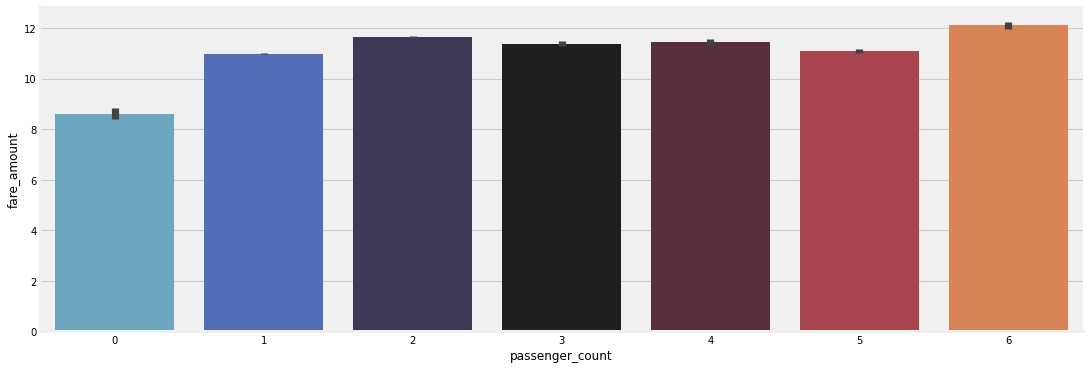

In [55]:
#passenger count feature

sns.catplot(x="passenger_count", y="fare_amount", palette="icefire", data=data, kind="bar", aspect=3)
sns.despine()
plt.show()

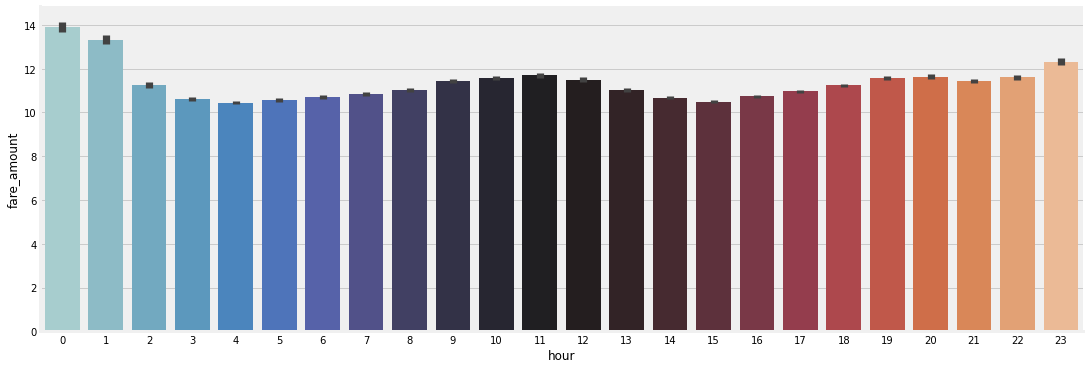

In [56]:
#fare amount by hour

sns.catplot(x="hour", y="fare_amount", palette="icefire", data=data, kind="bar", aspect=3)
sns.despine()
plt.show()

### CORRELATION BETWEEN FEATURES

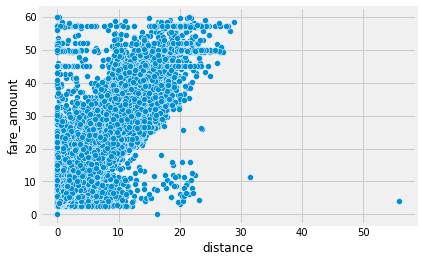

In [58]:
# Correlation between fare_amount and distance

sns.scatterplot(x="distance", y="fare_amount", palette="icefire",data=data[data.distance < 80].sample(100000))
plt.show()

In [59]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_bin,dow,hour,month,year,count,distance
0,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,"(0, 5.0]",2,10,4,2015,1,0.005783
1,0.0,2015-03-28 18:14:09 UTC,-73.987694,40.764881,-73.990150,40.761581,4,"(0, 5.0]",5,14,3,2015,1,0.421227
3,0.0,2010-02-26 22:10:53 UTC,-73.812794,40.695922,-73.993577,40.749743,1,"(0, 5.0]",4,17,2,2010,1,16.368200
4,0.0,2015-02-22 19:26:37 UTC,-73.994370,40.750725,-73.994370,40.750721,1,"(0, 5.0]",6,14,2,2015,1,0.000424
6,0.0,2015-05-24 03:16:52 UTC,-74.001633,40.730762,-73.999748,40.733494,1,"(0, 5.0]",5,23,5,2015,1,0.342713


# TRAINING

In [61]:
#starting on a fresh dataset to prepare for training

data_train=data_train = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows=1000)

### CLEANING DATASET

In [62]:
#cleaning dataset

def clean_data(df, test=False, predict=False):
    df = df.drop(["key"], axis=1)
    df = df.dropna(how='any', axis='rows')
    df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0)]
    df = df[(df.pickup_latitude != 0) | (df.pickup_longitude != 0)]
    if "fare_amount" in list(df):
        df = df[df.fare_amount.between(0, 4000)]
    df = df[df.passenger_count < 8]
    df = df[df.passenger_count >= 0]
    df = df[df["pickup_latitude"].between(left=40, right=42)]
    df = df[df["pickup_longitude"].between(left=-74.3, right=-72.9)]
    df = df[df["dropoff_latitude"].between(left=40, right=42)]
    df = df[df["dropoff_longitude"].between(left=-74, right=-72.9)]
    return df
data_train = clean_data(data_train)
data_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### PREPARING MODEL INPUTS

In [63]:
X_train = data_train.drop(["fare_amount"], axis=1)
y_train = data_train["fare_amount"]

### **PIPELINES**

#### TIME FEATURES

In [64]:
#class for time features encoding

class TimeFeaturesEncoder(BaseEstimator, TransformerMixin):
    #Extract the day of week (dow), the hour, the month and the year from a time column.

    def __init__(self, time_column, time_zone_name='America/New_York'):
        self.time_column = time_column
        self.time_zone_name = time_zone_name

    def extract_time_features(self, X):
        timezone_name = self.time_zone_name
        time_column = self.time_column
        df = X.copy()
        df.index = pd.to_datetime(df[time_column])
        df.index = df.index.tz_convert(timezone_name)
        df["dow"] = df.index.weekday
        df["hour"] = df.index.hour
        df["month"] = df.index.month
        df["year"] = df.index.year        
        return df
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        #Returns a copy of the DataFrame X with only four columns: 'dow', 'hour', 'month', 'year'
        return self.extract_time_features(X)[['dow', 'hour', 'month', 'year']].reset_index(drop=True)

In [65]:
#test of the TimeFeaturesEncoder

time_enc = TimeFeaturesEncoder('pickup_datetime')
time_features = time_enc.fit_transform(X_train, y_train)
time_features.head()

,dow,hour,month,year
0,0,13,6,2009
1,1,11,1,2010
2,2,20,8,2011
3,5,0,4,2012
4,1,2,3,2010


#### PIPELINE FOR TIME FEATURES

In [66]:
# TIME PIPELINE
pipe_time = Pipeline([
    ('time_features_create', TimeFeaturesEncoder('pickup_datetime')),
    ('time_features_ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
pipe_time

Pipeline(steps=[('time_features_create',
                 TimeFeaturesEncoder(time_column='pickup_datetime')),
                ('time_features_ohe',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

#### DISTANCES

In [69]:
# Class for distance encoding

def haversine_vectorized(df, 
         start_lat="pickup_latitude",
         start_lon="pickup_longitude",
         end_lat="dropoff_latitude",
         end_lon="dropoff_longitude"):
    
    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

In [70]:
class DistanceTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, 
                 start_lat="pickup_latitude",
                 start_lon="pickup_longitude", 
                 end_lat="dropoff_latitude", 
                 end_lon="dropoff_longitude"):
        self.start_lat = start_lat
        self.start_lon = start_lon
        self.end_lat = end_lat
        self.end_lon = end_lon

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        return pd.DataFrame(haversine_vectorized(X)).rename(columns={0: "course distance [km]"}).copy()

In [71]:
# Test of DistanceTransformer

dist_trans = DistanceTransformer()
distance = dist_trans.fit_transform(X_train, y_train)
distance.head()

,course distance [km]
0,1.030764
1,8.450134
2,1.389525
3,2.799270
4,1.999157


### COMBINATION OF DISTANCE AND TIME FEATURES PIPELINE

In [72]:
preprocessor = ColumnTransformer([
    ('distance', DistanceTransformer(), ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']),
    ('time', pipe_time, ['pickup_datetime'])
], remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('distance', DistanceTransformer(),
                                 ['pickup_longitude', 'pickup_latitude',
                                  'dropoff_longitude', 'dropoff_latitude']),
                                ('time',
                                 Pipeline(steps=[('time_features_create',
                                                  TimeFeaturesEncoder(time_column='pickup_datetime')),
                                                 ('time_features_ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['pickup_datetime'])])

### FULL PREPROCESSOR PIPELINE

In [73]:
pipe_prepro = Pipeline([
    ('dist_and_time', preprocessor),
    ('scaler', MinMaxScaler())
])
pipe_prepro

Pipeline(steps=[('dist_and_time',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('distance',
                                                  DistanceTransformer(),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude']),
                                                 ('time',
                                                  Pipeline(steps=[('time_features_create',
                                                                   TimeFeaturesEncoder(time_column='pickup_datetime')),
                                                                  ('time_features_ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['pickup_datetime'])])),
                ('scaler', MinMaxScaler())])

### FULL PIPELINE (Random Forest Generator)

In [74]:
final_pipe = Pipeline([
    ('preprocessor', pipe_prepro),
    ('model', RandomForestRegressor())
])
final_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('dist_and_time',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('distance',
                                                                   DistanceTransformer(),
                                                                   ['pickup_longitude',
                                                                    'pickup_latitude',
                                                                    'dropoff_longitude',
                                                                    'dropoff_latitude']),
                                                                  ('time',
                                                                   Pipeline(steps=[('time_features_create',
                                                                                    TimeFeaturesEncoder(time_column='pickup_datetime')),
                                                                                   ('time_features_ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   ['pickup_datetime'])])),
                                 ('scaler', MinMaxScaler())])),
                ('model', RandomForestRegressor())])

## Definition of custom score for RMSE

In [75]:
def custom_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

In [76]:
rmse = make_scorer(custom_rmse, greater_is_better=False)

### Baseline RMSE for RandomForestRegressor

In [77]:
baseline = cross_validate(final_pipe,
                          X_train,
                          y_train,
                          scoring=rmse,
                          cv=5)
baseline_rmse = -round(baseline["test_score"].mean(), 3)
baseline_rmse

4.67

### RandomisedSearchCV for an Optimised Model

In [78]:
grid_RFR = {'model__n_estimators': stats.randint(1, 300),
            'model__max_depth': stats.randint(1, 300),
            'model__max_samples': stats.randint(1, 300),
            "preprocessor__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]
            }

search_RFR = RandomizedSearchCV(final_pipe,
                                grid_RFR,
                                scoring=rmse,
                                n_iter=100,
                                cv=5,
                                n_jobs=-1,
                                verbose=True)
search_RFR.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


In [79]:
search_RFR.best_params_

{'model__max_depth': 175,
 'model__max_samples': 269,
 'model__n_estimators': 136,
 'preprocessor__scaler': RobustScaler()}

In [80]:
print("Tuned RandomForestRegressor model rmse: " + str(-round(search_RFR.best_score_, 2)))

Tuned RandomForestRegressor model rmse: 4.52
